## Example of Trans-C sampling across independent model states: State-Jump Sampler with Walker Pool Parallelization

This notebook demonstrates Bayesian sampling of a linear polynomial regression problem using the State-Jump sampler with walker pool parallelization. It includes performance scaling analysis and correctness validation comparing serial vs parallel execution.

In [1]:
# general python utility packages
import time
from collections import Counter
from functools import partial
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

import corner
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize

%matplotlib inline

In [2]:
from pytransc.analysis.samples import get_transc_samples
from pytransc.analysis.visits import (
    count_state_changes,
    count_total_state_changes,
    get_acceptance_rate_between_states,
    get_autocorr_between_state_jumps,
    get_relative_marginal_likelihoods,
    get_visits_to_states,
)
from pytransc.samplers import run_state_jump_sampler
from pytransc.utils.auto_pseudo import PseudoPriorBuilders, build_auto_pseudo_prior

In [3]:
def solveLS(d, G, Cdinv, mu=None, Cmpriorinv=None):  # Least squares solver
    """Solve the least squares problem given data, design matrix, and covariance matrices."""
    A = np.dot(np.transpose(G), Cdinv)  # Find solution
    GtG = np.dot(A, G)  # G^T C_inv G^T
    if (Cmpriorinv is not None) and (mu is not None):
        GtG += Cmpriorinv
    GtGinv = np.linalg.inv(GtG)  # Inverse of G^TC_inv G
    B = np.dot(A, d)
    if (Cmpriorinv is not None) and (mu is not None):
        B += np.dot(Cmpriorinv, mu)
    mls = np.dot(GtGinv, B)
    return mls, GtGinv

In [4]:
def calcE(dp, dobs, Cdinv, Cmpost, m, muprior, Cmpriorinv):
    """Calculate the evidence for the model given data, prior, and posterior covariances."""
    misfit = 0.5 * (np.dot((dobs - dp), np.dot(Cdinv, (dobs - dp))))
    misfit += 0.5 * (np.dot((muprior - m), np.dot(Cmpriorinv, (muprior - m))))
    f = np.sqrt(2 * np.pi) ** len(dp)
    detCdinv = np.linalg.det(Cdinv)
    detCmpost = np.linalg.det(Cmpost)
    detCmpriorinv = np.linalg.det(Cmpriorinv)
    E = np.sqrt(detCmpost * detCdinv * detCmpriorinv) * np.exp(-misfit) / f
    return E

--------

## Polynomial regression theory

Here we set up a problem of polynomial regression fitting a set of x,y data with up to a 4th order polynomial.

To begin with, we will work with polynomial curves, $$y(x) = \sum_{n=0}^N m_n x^n\,.$$
Here, $N$ is the 'order' of the polynomial: if $N=1$ we have a straight line, if $N=2$ it will be a quadratic, and so on. The $m_n$ are the 'model coefficients'.

To compute $y(x)$ for multiple $x$-values simultaneously, we  write $$ \left(\begin{array}{c}y_1\\y_2\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_N&x_N^2\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$This has the general form, $\mathbf{d=Gm}$, and so the best-fitting model can be identified using a least-squares algorithm.

The maximum Likelihood solution for this problem is the model which minimizes

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}),
$$
which leads to

$$
{\bf m}_{LS} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G}\right)^{-1}\mathbf{G}^T  C_D^{-1} \mathbf{d}.
$$

The *MAP* model, $\hat{{\bf m}}$, for this problem minimizes of the sum of the negative log-Likelihood and log-Gaussian prior 

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}) + \frac{1}{2} (\mathbf{m - m_o})^TC_M^{-1} (\mathbf{m - m_o})
$$

which leads to

$$
\hat{{\bf m}} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}(\mathbf{G}^T  C_D^{-1} \mathbf{d} + C_M^{-1}\mathbf{m_o}).
$$

For Gaussian Likelihood and prior the evidence is a known analytical expression.

$$
p{({\bf d}) = \frac{e^{-\phi(\hat{{\bf m}})}}{(2\pi)^{N/2}} \left[ \frac{|\hat{C}_M|}{|C_D||C_M|}\right]^{1/2}.
$$
where $\hat{C}_M$ is the posterior model covariance, 

$$
\hat{C}_M = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}
$$

In [5]:
def getG(x, order):
    """Build design matrix, G for polynomial data fitting, at data points x up to order order."""
    return np.transpose([x ** (i) for i in range(order + 1)])

We generate some random samples from $y=3x/5+0.3$, add Gaussian random noise to them.

In [6]:
np.random.seed(61254557)  # noqa: NPY002
ndata, sigma = 20, 0.2
xobs = np.sort(np.random.rand(ndata))  # noqa: NPY002 ; x values of data
mtrue = np.array([0.3, 0.6])
G = getG(xobs, 1)
dobs = np.dot(G, mtrue) + np.random.normal(0, sigma, size=len(xobs))  # noqa: NPY002
Cdinv = np.eye(ndata) / (sigma**2)

Set up prior for Evidence calculation.

In [7]:
mls = []
Cmpost = []
G = []
Ev = []
maxorder = 3
Cmprior = [20 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
Cmpriorinv = [0.05 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
muprior = [np.zeros(i + 1) for i in np.arange(maxorder + 1)]

Solve least squares solution and calculate evidence for each model.

In [8]:
for i in range(maxorder + 1):
    Gp = getG(xobs, i)
    solp, Cmp = solveLS(dobs, Gp, Cdinv)  # Maximum Likelihood solution
    dpred = np.dot(Gp, solp)
    mls.append(solp)
    Cmpost.append(Cmp)
    G.append(Gp)
    solp2, Cmp2 = solveLS(
        dobs, Gp, Cdinv, mu=muprior[i], Cmpriorinv=Cmpriorinv[i]
    )  # MAP model and model covariance with Gaussian prior
    dpred2 = np.dot(Gp, solp2)
    Ev.append(
        calcE(dpred2, dobs, Cdinv, Cmp2, solp2, muprior[i], Cmpriorinv[i])
    )  # Analytical evidence calculation
Ev /= np.sum(Ev)

Plot solutions.

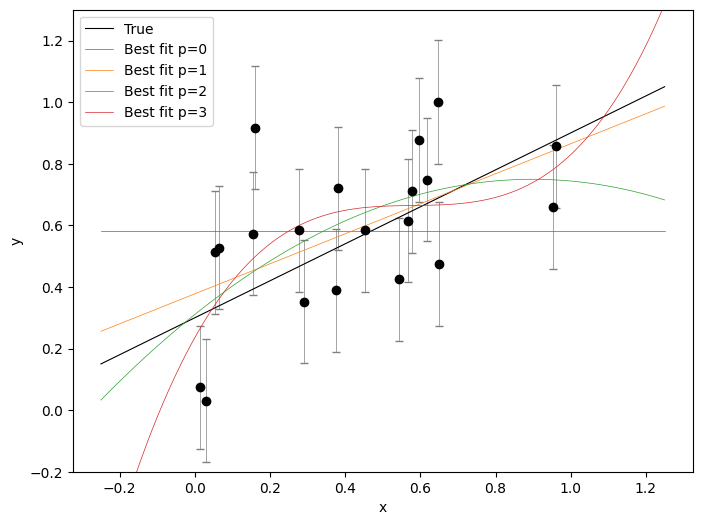

In [9]:
xplot = np.linspace(-0.25, 1.25, 100)
Gplot = getG(xplot, 1)
dplot = np.dot(Gplot, mtrue)
#
plt.figure(figsize=(8, 6))
plt.errorbar(xobs, dobs, yerr=sigma, capsize=3, fmt="ko", ecolor="grey", lw=0.5)
plt.plot(xplot, dplot, label="True", color="k", lw=0.8)
for i in range(maxorder + 1):
    Gplotp = getG(xplot, i)
    dpred = np.dot(Gplotp, mls[i])
    plt.plot(xplot, dpred, label="Best fit p=" + str(i), lw=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-0.2, 1.3)
# plt.savefig('ML_solutions.pdf')
plt.legend()
plt.show()

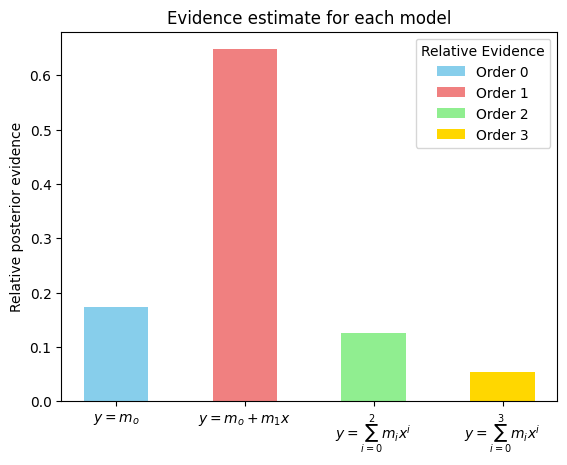

In [10]:
# plot evidence values

fig, ax = plt.subplots()

fruits = [
    r"$y=m_o$",
    r"$y=m_o + m_1x$",
    r"$y = \sum_{i=0}^2 m_ix^i$",
    r"$y = \sum_{i=0}^3 m_ix^i$",
]
counts = [Ev[i] for i in range(maxorder + 1)]
bar_labels = [
    "Order 0",
    "Order 1",
    "Order 2",
    "Order 3",
]  # Define a list of labels, one for each bar

bar_colors = [
    "skyblue",
    "lightcoral",
    "lightgreen",
    "gold",
]  # Define a list of colors, one for each bar

ax.bar(fruits, counts, label=bar_labels, width=0.5, color=bar_colors)

ax.set_ylabel("Relative posterior evidence")
ax.set_title("Evidence estimate for each model")
ax.legend(title="Relative Evidence")
# plt.savefig('Anal_evidence.pdf')

plt.show()

In [11]:
Ev

array([0.17305995, 0.64751747, 0.12509365, 0.05432893])

----------------

### Log-posterior Likelihood, prior and PDF for each state

In [12]:
def _log_likelihood(x, state, dobs, G, Cdinv):
    """Calculate the log likelihood of the data given the model parameters."""
    dpred = np.dot(G[state], x)
    misfit = 0.5 * (np.dot((dobs - dpred), np.dot(Cdinv, (dobs - dpred))))
    f = np.sqrt(2 * np.pi) ** len(dpred)
    detCdinv = np.linalg.det(Cdinv)
    logL = -np.log(f) - misfit + np.log(detCdinv)
    return logL


log_likelihood = partial(_log_likelihood, dobs=dobs, G=G, Cdinv=Cdinv)

In [13]:
def _log_prior(x, state, muprior, Cmprior):
    """Calculate the log prior probability of the model parameters."""
    mu = muprior[state]
    cov = Cmprior[state]
    rv = stats.multivariate_normal(
        mean=mu, cov=cov
    )  # instance of multi-dimensional Gaussian
    return rv.logpdf(x)


log_prior = partial(_log_prior, muprior=muprior, Cmprior=Cmprior)

In [14]:
def log_posterior(x, state):
    """Multi-state log Posterior PDF evaluation (unormalised)."""
    return log_likelihood(x, state) + log_prior(x, state)

### Starting points for MCMC samplers in each state

In [15]:
# first we optimize each state to find good starting point for all McMC samplers
rng = np.random.default_rng(42)
nstates = maxorder + 1  # Number of distinct states
ndims = [1, 2, 3, 4]  # Number of model parameters in each state
nll = lambda *args: -log_posterior(*args)
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    initial = 0.5 * np.ones(i + 1)
    soln = minimize(nll, initial, args=(i,))
    ml.append(soln.x)
    print("x_ml ", soln.x)

Maximum likelihood estimates:
x_ml  [0.58148024]
x_ml  [0.37788932 0.48664354]
x_ml  [ 0.31354801  0.95796058 -0.52400541]
x_ml  [ 0.28548373  1.4395107  -1.83289387  0.89632873]


### Pseudo-prior for each state

Here we use an automatic pseudo prior for each state which corresponds to a best fit multi-dimensional Gaussian to posterior ensembles in each state.

This is built using the function `build_auto_pseudo_prior()` which returns a function which we'll call `log_pseudo_prior()`. 

`build_auto_pseudo_prior()` will conduct some quick initial sampling in each state, and fit a Gaussian Mixture to these samples.

In [16]:
# This generates posterior samples in each state and fits a Gaussian to them to become the pseudo prior
nwalkers_auto = 32  # Number of walkers for auto pseudo prior fitting
nsteps_auto = 1000  # Number of chain steps for auto pseudo prior fitting
autothin = True  # Thin internally generated within state posterior ensembles by their auto-correlation
# (This can take additional compute time, and is not necessary if input ensembles are already independent.)
pos = []
for i in range(nstates):  # generate starting points for each chain in each state
    pos.append(
        ml[i] + 1e-4 * rng.standard_normal((nwalkers_auto, ndims[i]))
    )  # add random perturbation to maximum Likelihood models

sampling_args = {
    "n_states": nstates,
    "n_dims": ndims,
    "n_walkers": nwalkers_auto,
    "n_steps": nsteps_auto,
    "pos": pos,
    "auto_thin": autothin,
    "verbose": False,
}

log_pseudo_prior = build_auto_pseudo_prior(  # noqa: F811
    PseudoPriorBuilders.GAUSSIAN_MIXTURE,
    log_posterior=log_posterior,
    sampling_args=sampling_args,
)

-----------

Now we are ready to apply the State-Jump sampler with walker pool parallelization.

## Trans-C sampling across model states with the State-Jump sampler and Walker Pool Parallelization

Here we demonstrate use of the *State-jump sampler* with walker pool parallelization.

This formulation is equivalent to the *Product-space sampler* with the proposal for the other state variables equal to the pseudo prior, for which moves are then accepted with probability one. As a consequence  the only pair of model states that need be considered are the $k$ and $k^{\prime}$ states (i.e. same as in Reversible-Jump). 

- For within-state moves the acceptance is the usual M-H condition with proposal = to users choice for that state, defined by routine `log_proposal`
  This can be any perturbative proposal PDF designed by the user, or an automatic one found by fitting a Gaussian mixture model to some trial samples.

- For between-state moves we assume that only the state index changes, $k \rightarrow k^{\prime}$ , and hence the model in state $k^{\prime}$ must be a draw from the pseduo prior for that state. The acceptance term then only involves the likelihood ratio and the pseudo prior ratio for the two states.

**Walker Pool Parallelization**: Each walker runs independently and can be parallelized across multiple processors using either a user-provided pool or internal ProcessPoolExecutor.

In [17]:
# define model proposal for within state moves


class IsotropicGaussianProposal:
    """Class for isotropic Gaussian proposal for state jump sampler."""

    def __init__(self):
        self.std = [
            [0.01],
            [0.04, 0.05],
            [0.04, 0.2, 0.2],
            [0.05, 0.5, 1.0, 1.0],
        ]  # Proposal variance for each parameter in state

    def __call__(self, x: np.ndarray, state: int) -> float:
        """Call method to generate proposal."""
        return 0.0  # log ratio for symmetric proposal

    def propose(self, x: np.ndarray, state: int) -> np.ndarray:
        """Propose from the proposal distribution."""
        i = rng.choice(np.arange(len(x)))
        var = self.std[state][i] ** 2
        _x = np.copy(x)
        _x[i] += stats.multivariate_normal.rvs(mean=0.0, cov=var)
        if not isinstance(_x, np.ndarray):
            _x = np.array([_x])  # deal with 1D case which returns a scalar
        return _x


log_proposal = IsotropicGaussianProposal()

In [18]:
# starting points of MCMC chains
nwalkers_sj = 32  # Number of walkers
nsteps_sj = 10000  # Number of chain steps
pos_states = rng.choice(
    np.arange(nstates), nwalkers_sj
)  # Initial states of each walker
pos = []
for i in range(nwalkers_sj):  # generate starting points for each walker
    pos.append(
        ml[pos_states[i]] + 1e-4 * rng.standard_normal(ndims[pos_states[i]])
    )  # add random perturbation to maximum Likelihood models

## Performance Scaling Analysis

We'll test the performance scaling with different numbers of workers (1, 2, 4, 8) and compare with serial execution.

In [19]:
# Test different worker counts for performance analysis
worker_counts = [1, 2, 4, 8]
max_workers = min(8, multiprocessing.cpu_count())  # Don't exceed available CPUs
worker_counts = [w for w in worker_counts if w <= max_workers]

print(f"Available CPUs: {multiprocessing.cpu_count()}")
print(f"Testing worker counts: {worker_counts}")

# Storage for timing results
timing_results = {
    'serial': None,
    'parallel': {}
}

Available CPUs: 12
Testing worker counts: [1, 2, 4, 8]


### Serial Execution Baseline

In [20]:
# Serial execution for baseline
print("\n=== SERIAL EXECUTION ===")
start_time = time.time()
state_jump_chains_serial = run_state_jump_sampler(
    nwalkers_sj,
    nsteps_sj,
    nstates,
    ndims,
    pos,
    pos_states,
    log_posterior,
    log_pseudo_prior,
    log_proposal,
    parallel=False,  # Serial execution
    progress=True,
)
serial_time = time.time() - start_time
timing_results['serial'] = serial_time

print(f"Serial execution time: {serial_time:.2f} seconds")

2025-09-22 18:48:12 [INFO] pytransc.samplers.state_jump: Running state-jump trans-C sampler
2025-09-22 18:48:12 [INFO] pytransc.samplers.state_jump: Number of walkers: 32
2025-09-22 18:48:12 [INFO] pytransc.samplers.state_jump: Number of states being sampled: 4
2025-09-22 18:48:12 [INFO] pytransc.samplers.state_jump: Dimensions of each state: [1, 2, 3, 4]



=== SERIAL EXECUTION ===


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:31<00:00,  2.86s/it]

Serial execution time: 91.65 seconds


### Parallel Execution with Different Worker Counts

In [21]:
# Parallel execution with different worker counts
parallel_results = {}

for n_workers in worker_counts:
    print(f"\n=== PARALLEL EXECUTION WITH {n_workers} WORKERS ===")
    
    # Using user-provided pool
    start_time = time.time()
    with ProcessPoolExecutor(max_workers=n_workers) as walker_pool:
        state_jump_chains_parallel = run_state_jump_sampler(
            nwalkers_sj,
            nsteps_sj,
            nstates,
            ndims,
            pos,
            pos_states,
            log_posterior,
            log_pseudo_prior,
            log_proposal,
            walker_pool=walker_pool,  # User-provided pool
            progress=True,
        )
    parallel_time = time.time() - start_time
    timing_results['parallel'][n_workers] = parallel_time
    parallel_results[n_workers] = state_jump_chains_parallel
    
    speedup = serial_time / parallel_time if parallel_time > 0 else 0
    efficiency = speedup / n_workers * 100 if n_workers > 0 else 0
    
    print(f"Parallel execution time ({n_workers} workers): {parallel_time:.2f} seconds")
    print(f"Speedup: {speedup:.2f}x")
    print(f"Efficiency: {efficiency:.1f}%")

2025-09-22 18:49:44 [INFO] pytransc.samplers.state_jump: Running state-jump trans-C sampler
2025-09-22 18:49:44 [INFO] pytransc.samplers.state_jump: Number of walkers: 32
2025-09-22 18:49:44 [INFO] pytransc.samplers.state_jump: Number of states being sampled: 4
2025-09-22 18:49:44 [INFO] pytransc.samplers.state_jump: Dimensions of each state: [1, 2, 3, 4]



=== PARALLEL EXECUTION WITH 1 WORKERS ===


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:32<00:00,  2.90s/it]
2025-09-22 18:51:17 [INFO] pytransc.samplers.state_jump: Running state-jump trans-C sampler
2025-09-22 18:51:17 [INFO] pytransc.samplers.state_jump: Number of walkers: 32
2025-09-22 18:51:17 [INFO] pytransc.samplers.state_jump: Number of states being sampled: 4
2025-09-22 18:51:17 [INFO] pytransc.samplers.state_jump: Dimensions of each state: [1, 2, 3, 4]


Parallel execution time (1 workers): 92.82 seconds
Speedup: 0.99x
Efficiency: 98.7%

=== PARALLEL EXECUTION WITH 2 WORKERS ===


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:46<00:00,  1.44s/it]
2025-09-22 18:52:03 [INFO] pytransc.samplers.state_jump: Running state-jump trans-C sampler
2025-09-22 18:52:03 [INFO] pytransc.samplers.state_jump: Number of walkers: 32
2025-09-22 18:52:03 [INFO] pytransc.samplers.state_jump: Number of states being sampled: 4
2025-09-22 18:52:03 [INFO] pytransc.samplers.state_jump: Dimensions of each state: [1, 2, 3, 4]


Parallel execution time (2 workers): 46.20 seconds
Speedup: 1.98x
Efficiency: 99.2%

=== PARALLEL EXECUTION WITH 4 WORKERS ===


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:23<00:00,  1.39it/s]
2025-09-22 18:52:26 [INFO] pytransc.samplers.state_jump: Running state-jump trans-C sampler
2025-09-22 18:52:26 [INFO] pytransc.samplers.state_jump: Number of walkers: 32
2025-09-22 18:52:26 [INFO] pytransc.samplers.state_jump: Number of states being sampled: 4
2025-09-22 18:52:26 [INFO] pytransc.samplers.state_jump: Dimensions of each state: [1, 2, 3, 4]


Parallel execution time (4 workers): 23.12 seconds
Speedup: 3.96x
Efficiency: 99.1%

=== PARALLEL EXECUTION WITH 8 WORKERS ===


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:11<00:00,  2.73it/s]

Parallel execution time (8 workers): 11.75 seconds
Speedup: 7.80x
Efficiency: 97.5%


### Internal Pool Creation Test

In [22]:
# Test internal pool creation (parallel=True, walker_pool=None)
print(f"\n=== INTERNAL POOL CREATION (parallel=True) ===")
start_time = time.time()
state_jump_chains_internal = run_state_jump_sampler(
    nwalkers_sj,
    nsteps_sj,
    nstates,
    ndims,
    pos,
    pos_states,
    log_posterior,
    log_pseudo_prior,
    log_proposal,
    parallel=True,  # Use internal pool creation
    n_processors=4,
    progress=True,
)
internal_time = time.time() - start_time
speedup_internal = serial_time / internal_time if internal_time > 0 else 0

print(f"Internal pool execution time: {internal_time:.2f} seconds")
print(f"Speedup: {speedup_internal:.2f}x")

2025-09-22 18:52:38 [INFO] pytransc.samplers.state_jump: Running state-jump trans-C sampler
2025-09-22 18:52:38 [INFO] pytransc.samplers.state_jump: Number of walkers: 32
2025-09-22 18:52:38 [INFO] pytransc.samplers.state_jump: Number of states being sampled: 4
2025-09-22 18:52:38 [INFO] pytransc.samplers.state_jump: Dimensions of each state: [1, 2, 3, 4]



=== INTERNAL POOL CREATION (parallel=True) ===


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]

Internal pool execution time: 23.32 seconds
Speedup: 3.93x


### Performance Scaling Plot

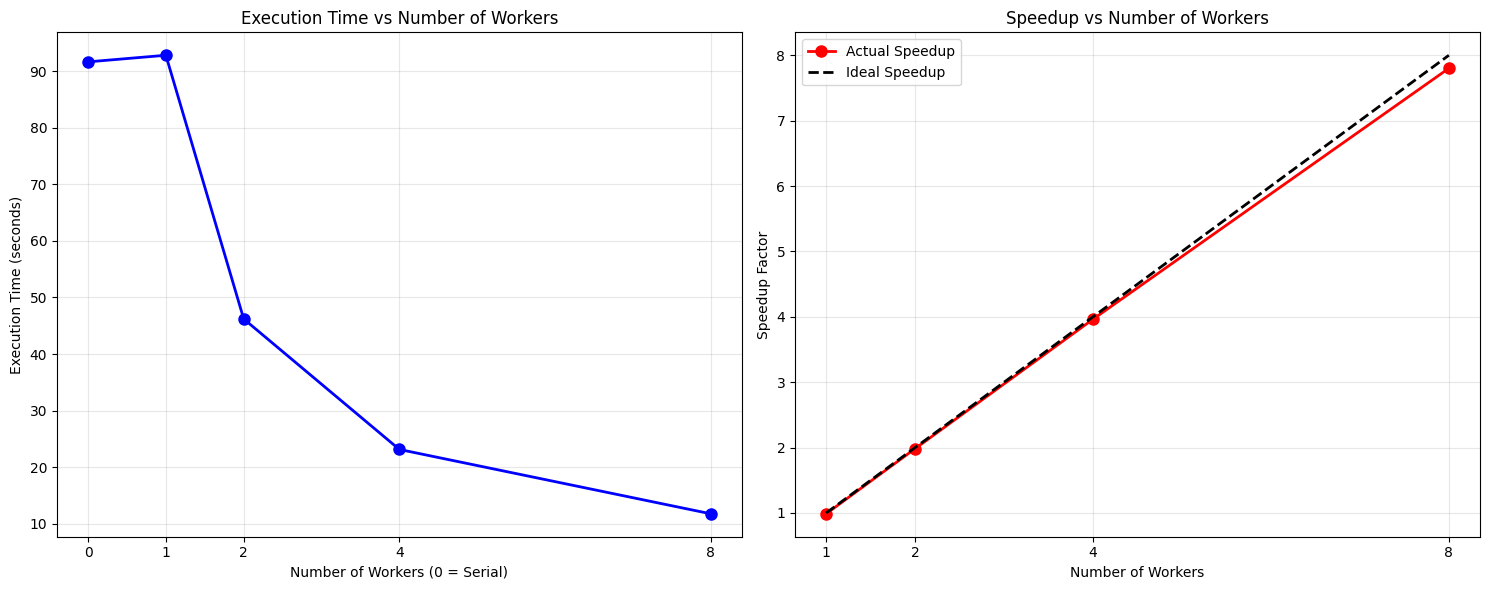


=== PERFORMANCE SUMMARY ===
Workers  Time (s)   Speedup    Efficiency (%) 
--------------------------------------------------
Serial   91.65      1.00       100.0          
1        92.82      0.99       98.7           
2        46.20      1.98       99.2           
4        23.12      3.96       99.1           
8        11.75      7.80       97.5           


In [23]:
# Plot performance scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Execution time plot
workers = [0] + worker_counts  # 0 for serial
times = [serial_time] + [timing_results['parallel'][w] for w in worker_counts]

ax1.plot(workers, times, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Workers (0 = Serial)')
ax1.set_ylabel('Execution Time (seconds)')
ax1.set_title('Execution Time vs Number of Workers')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(workers)

# Speedup plot
speedups = [serial_time / timing_results['parallel'][w] for w in worker_counts]
ideal_speedup = worker_counts  # Ideal linear speedup

ax2.plot(worker_counts, speedups, 'ro-', linewidth=2, markersize=8, label='Actual Speedup')
ax2.plot(worker_counts, ideal_speedup, 'k--', linewidth=2, label='Ideal Speedup')
ax2.set_xlabel('Number of Workers')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup vs Number of Workers')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xticks(worker_counts)

plt.tight_layout()
plt.show()

# Print efficiency table
print("\n=== PERFORMANCE SUMMARY ===")
print(f"{'Workers':<8} {'Time (s)':<10} {'Speedup':<10} {'Efficiency (%)':<15}")
print("-" * 50)
print(f"{'Serial':<8} {serial_time:<10.2f} {'1.00':<10} {'100.0':<15}")
for w in worker_counts:
    t = timing_results['parallel'][w]
    speedup = serial_time / t
    efficiency = speedup / w * 100
    print(f"{w:<8} {t:<10.2f} {speedup:<10.2f} {efficiency:<15.1f}")

## Correctness Validation: Serial vs Parallel

We'll verify that parallel execution produces statistically equivalent results to serial execution.

In [24]:
def analyze_chains(chains, name):
    """Analyze chain results and return summary statistics."""
    # Calculate acceptance rates
    accept_within_per_walker = chains.accept_within / chains.prop_within
    accept_between_per_walker = chains.accept_between / chains.prop_between
    accept_within = 100 * np.mean(accept_within_per_walker)
    accept_between = 100 * np.mean(accept_between_per_walker)
    
    # Calculate state visit statistics
    discard = 0
    thin = 20
    relative_marginal_likelihoods = get_relative_marginal_likelihoods(
        chains.state_chain_tot[:, -1, :]
    )
    
    total_state_changes = count_total_state_changes(
        chains.state_chain, discard=discard, thin=thin
    )
    
    autocorr_time_for_between_state_jumps = get_autocorr_between_state_jumps(
        chains.state_chain
    )
    
    results = {
        'name': name,
        'accept_within': accept_within,
        'accept_between': accept_between,
        'relative_evidences': relative_marginal_likelihoods,
        'total_state_changes': total_state_changes,
        'autocorr_time': autocorr_time_for_between_state_jumps
    }
    
    return results

# Analyze serial and parallel results
serial_analysis = analyze_chains(state_jump_chains_serial, "Serial")
parallel_analysis = analyze_chains(parallel_results[4], "Parallel (4 workers)")  # Use 4 workers for comparison

print("\n=== CORRECTNESS VALIDATION ===")
print(f"Analytical relative evidences: {np.round(Ev, 5)}")
print()

for analysis in [serial_analysis, parallel_analysis]:
    print(f"{analysis['name']} Results:")
    print(f"  Average % acceptance rate within states:  {analysis['accept_within']:.2f}")
    print(f"  Average % acceptance rate between states: {analysis['accept_between']:.2f}")
    print(f"  Estimated relative evidences: {np.round(analysis['relative_evidences'], 5)}")
    print(f"  Total state changes: {analysis['total_state_changes']}")
    print(f"  Autocorr time for between state jumps: {analysis['autocorr_time']:.3f}")
    print()

# Calculate differences
evidence_diff = np.abs(serial_analysis['relative_evidences'] - parallel_analysis['relative_evidences'])
acceptance_within_diff = abs(serial_analysis['accept_within'] - parallel_analysis['accept_within'])
acceptance_between_diff = abs(serial_analysis['accept_between'] - parallel_analysis['accept_between'])

print("Differences (Serial vs Parallel):")
print(f"  Max evidence difference: {np.max(evidence_diff):.5f}")
print(f"  Within-state acceptance difference: {acceptance_within_diff:.2f}%")
print(f"  Between-state acceptance difference: {acceptance_between_diff:.2f}%")

# Tolerance check
evidence_tolerance = 0.01  # 1% tolerance
acceptance_tolerance = 2.0  # 2% tolerance

evidence_ok = np.all(evidence_diff < evidence_tolerance)
acceptance_ok = (acceptance_within_diff < acceptance_tolerance and 
                acceptance_between_diff < acceptance_tolerance)

print(f"\nValidation Results:")
print(f"  Evidence estimates within tolerance ({evidence_tolerance}): {'✓' if evidence_ok else '✗'}")
print(f"  Acceptance rates within tolerance ({acceptance_tolerance}%): {'✓' if acceptance_ok else '✗'}")
print(f"  Overall validation: {'✓ PASSED' if evidence_ok and acceptance_ok else '✗ FAILED'}")


=== CORRECTNESS VALIDATION ===
Analytical relative evidences: [0.17306 0.64752 0.12509 0.05433]

Serial Results:
  Average % acceptance rate within states:  75.63
  Average % acceptance rate between states: 38.63
  Estimated relative evidences: [0.17498 0.64817 0.1224  0.05445]
  Total state changes: 6353
  Autocorr time for between state jumps: 19.418

Parallel (4 workers) Results:
  Average % acceptance rate within states:  75.77
  Average % acceptance rate between states: 38.61
  Estimated relative evidences: [0.1723  0.65191 0.1251  0.05069]
  Total state changes: 6309
  Autocorr time for between state jumps: 17.687

Differences (Serial vs Parallel):
  Max evidence difference: 0.00376
  Within-state acceptance difference: 0.14%
  Between-state acceptance difference: 0.02%

Validation Results:
  Evidence estimates within tolerance (0.01): ✓
  Acceptance rates within tolerance (2.0%): ✓
  Overall validation: ✓ PASSED


### Evidence Comparison Plot

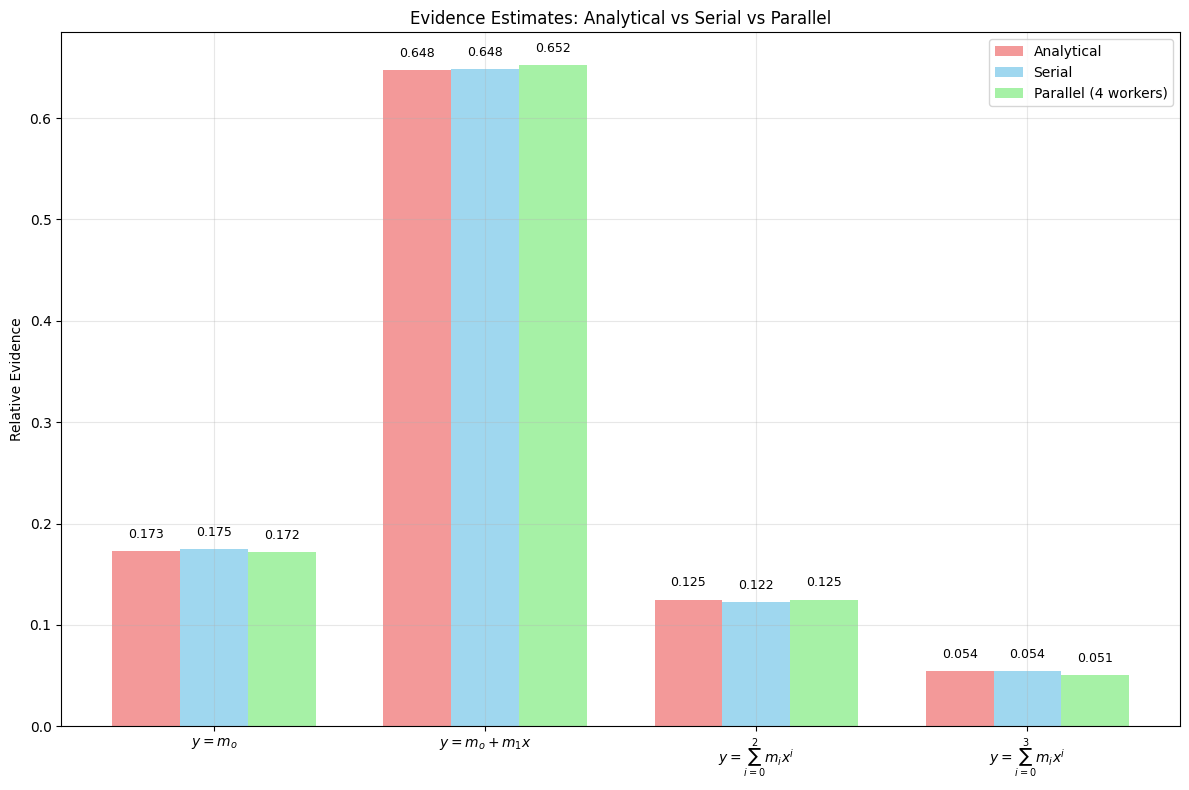

In [25]:
# Plot evidence comparison
labels = [r"$y=m_o$", r"$y=m_o + m_1x$", r"$y = \sum_{i=0}^2 m_ix^i$", r"$y = \sum_{i=0}^3 m_ix^i$"]
x = np.arange(nstates)
width = 0.25

fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars
analytical_bars = ax.bar(x - width, Ev, width, label='Analytical', color='lightcoral', alpha=0.8)
serial_bars = ax.bar(x, serial_analysis['relative_evidences'], width, label='Serial', color='skyblue', alpha=0.8)
parallel_bars = ax.bar(x + width, parallel_analysis['relative_evidences'], width, label='Parallel (4 workers)', color='lightgreen', alpha=0.8)

# Add value labels on bars
def add_value_labels(bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

add_value_labels(analytical_bars, Ev)
add_value_labels(serial_bars, serial_analysis['relative_evidences'])
add_value_labels(parallel_bars, parallel_analysis['relative_evidences'])

ax.set_ylabel('Relative Evidence')
ax.set_title('Evidence Estimates: Analytical vs Serial vs Parallel')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrates the walker pool parallelization feature of the State-Jump sampler:

1. **Performance Scaling**: Shows how execution time decreases with increasing number of workers
2. **Correctness Validation**: Verifies that parallel execution produces statistically equivalent results to serial execution
3. **Usage Patterns**: Demonstrates both user-provided pools and internal pool creation

The parallelization provides significant speedup while maintaining the accuracy and statistical properties of the serial implementation.